In [141]:

import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import re
import nltk
import os
import smart_open
import collections
import scipy.stats as stats
import tensorflow as tf
import gensim

from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import common_texts
from gensim.test.utils import get_tmpfile

from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten, LSTM, Conv1D, Conv2D, GlobalAveragePooling1D,LayerNormalization 
from tensorflow.keras.layers import Bidirectional, GlobalAveragePooling2D, GlobalAveragePooling3D, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
#from sklearn.model_selection import GridSearchCV, RandomSearch
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, tree
import xgboost

In [9]:
os.chdir('/Users/patrickrs/Documents/GitLab/patrick-steiner/Exercises')
target = pd.read_csv('../data/data/train_target.csv', index_col = 0)
features = pd.read_csv('data/train_features.csv', index_col = 0)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/patrickrs/Documents/GitLab/patrick-steiner/Exercises'

In [10]:
#TO DO: Clean the columns (removing missing values)
nltk.download('stopwords')
STOP_WORDS = nltk.corpus.stopwords.words('english')

def clean_sentence(val):
    "remove chars that are not letters or numbers, downcase, then remove stop words"
    regex = re.compile('([^\s\w]|_)+')
    sentence = regex.sub('', val).lower()
    sentence = re.sub("xxxx", "", sentence)
    sentence = re.sub("xxx", "", sentence)
    sentence = re.sub("xx", "", sentence)
    sentence = re.sub("\s\s+", " ", sentence)
       
    # stemming of words (seems not to affect accuracy, but should make things faster
    porter = PorterStemmer()
    words = word_tokenize(sentence)
    sentence = " ".join([porter.stem(word) for word in words])
      
    sentence = sentence.split(" ")
    for word in list(sentence):
        if word in STOP_WORDS:
            sentence.remove(word)  
    sentence = " ".join(sentence)
    
    return sentence

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/patrickrs/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
features['Consumer complaint narrative'] = [clean_sentence(narrative) for narrative in features['Consumer complaint narrative']]

In [12]:
features = features['Consumer complaint narrative']

In [13]:
#Build Corpus:
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for content in data:
        corpus_temp = nltk.word_tokenize(content)
        corpus.append(corpus_temp)
    return corpus

corpus = build_corpus(features)

In [14]:
# Importing pre-trained model, updating vocab 
# and training the model (takes long to run)
model_2 = Word2Vec(size=300, min_count=1)
model_2.build_vocab(corpus)
total_examples = model_2.corpus_count
model_pt = gensim.models.KeyedVectors.load_word2vec_format('/Users/patrickrs/Documents/Gitlab/patrick-steiner/revealapp/00_exploration/Pat/GoogleNews-vectors-negative300.bin', binary=True)
model_2.build_vocab([list(model_pt.vocab.keys())], update=True)
model_2.intersect_word2vec_format('/Users/patrickrs/Documents/Gitlab/patrick-steiner/revealapp/00_exploration/Pat/GoogleNews-vectors-negative300.bin', binary=True, lockf=1.0)
# intersect_word2vec_format() will let you bring vectors from an external file into a model that's already had its own vocabulary initialized
# see https://tedboy.github.io/nlps/generated/generated/gensim.models.Word2Vec.intersect_word2vec_format.html
model_2.train(corpus, total_examples=total_examples, epochs=model_2.iter)

/Users/patrickrs/.conda/envs/pre-work/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  # This is added back by InteractiveShellApp.init_path()


(12849371, 12874500)

In [15]:
embedding_matrix = np.zeros((len(model_2.wv.vocab) + 1, 300))
for i, vec in enumerate(model_2.wv.vectors):
  embedding_matrix[i] = vec

In [16]:
feature_size = 500
tokenizer = Tokenizer(num_words = feature_size)
# fit the tokenizer on our text
tokenizer.fit_on_texts(features)

In [17]:
# get all words that the tokenizer knows
word_index = tokenizer.word_index

In [18]:
# put the tokens in a matrix
X = tokenizer.texts_to_sequences(features)
X = pad_sequences(X)

In [19]:
# prepare the labels
y = pd.get_dummies(target)

In [20]:
# split in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# 1st Model: Google W2V, LSTM-300 + Dense-12

In [21]:
# init model
model = Sequential()
# emmbed word vectors
model.add(Embedding(len(model_2.wv.vocab) + 1 ,
                    300,
                    input_length  = X.shape[1],
                    weights = [embedding_matrix],
                    trainable=False))
# learn the correlations
model.add(LSTM(300,return_sequences=False))
model.add(Dense(12,activation="softmax")) 
# output model skeleton
model.summary()
model.compile(optimizer="nadam",loss="categorical_crossentropy",metrics=['acc'])

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1892, 300)         905363400 
_________________________________________________________________
lstm (LSTM)                  (None, 300)               721200    
_________________________________________________________________
dense (Dense)                (None, 12)                3612      
Total params: 906,088,212
Trainable params: 724,812
Non-trainable params: 905,363,400
_________________________________________________________________


In [22]:
batch = 64
epochs = 12
model.fit(X_train,y_train,batch,epochs)

Instructions for updating:
Use tf.cast instead.
Epoch 1/12
21600/21600 [==============================] - 7163s 332ms/sample - loss: 2.3766 - acc: 0.1551
Epoch 2/12
21600/21600 [==============================] - 6870s 318ms/sample - loss: 1.9686 - acc: 0.2972
Epoch 3/12
21600/21600 [==============================] - 6740s 312ms/sample - loss: 1.7790 - acc: 0.3624
Epoch 4/12
21600/21600 [==============================] - 7460s 345ms/sample - loss: 1.6955 - acc: 0.3931
Epoch 5/12
21600/21600 [==============================] - 6896s 319ms/sample - loss: 1.6937 - acc: 0.3914
Epoch 6/12
21600/21600 [==============================] - 6610s 306ms/sample - loss: 1.6336 - acc: 0.4055
Epoch 7/12
21600/21600 [==============================] - 6627s 307ms/sample - loss: 1.5396 - acc: 0.4344
Epoch 8/12
21600/21600 [==============================] - 6619s 306ms/sample - loss: 1.4767 - acc: 0.4607
Epoch 9/12
21600/21600 [==============================] - 6612s 306ms/sample - loss: 1.4291 - acc: 0.475

In [23]:
model.evaluate(X_test,y_test)

2400/2400 [==============================] - 156s 65ms/sample - loss: 1.4867 - acc: 0.4533


[1.4866717847188313, 0.45333335]

In [25]:
model.fit(X_train,y_train,batch,epochs)

Epoch 1/12
21600/21600 [==============================] - 6924s 321ms/sample - loss: 1.3272 - acc: 0.5113
Epoch 2/12
21600/21600 [==============================] - 6593s 305ms/sample - loss: 1.3199 - acc: 0.5189
Epoch 3/12
21600/21600 [==============================] - 6574s 304ms/sample - loss: 1.2796 - acc: 0.5251
Epoch 4/12
21600/21600 [==============================] - 6680s 309ms/sample - loss: 1.2594 - acc: 0.5329
Epoch 5/12
21600/21600 [==============================] - 6706s 310ms/sample - loss: 1.2470 - acc: 0.5393
Epoch 6/12
21600/21600 [==============================] - 6654s 308ms/sample - loss: 1.2331 - acc: 0.5409
Epoch 7/12
21600/21600 [==============================] - 6668s 309ms/sample - loss: 1.2212 - acc: 0.5476
Epoch 8/12
21600/21600 [==============================] - 6677s 309ms/sample - loss: 1.1907 - acc: 0.5590
Epoch 9/12
21600/21600 [==============================] - 6693s 310ms/sample - loss: 1.1746 - acc: 0.5633
Epoch 10/12
21600/21600 [=====================

In [26]:
model.evaluate(X_test,y_test)

2400/2400 [==============================] - 155s 65ms/sample - loss: 1.3544 - acc: 0.5038


[1.3544303011894225, 0.50375]

In [27]:
model.fit(X_train,y_train,batch,6)

Epoch 1/6
21600/21600 [==============================] - 6815s 315ms/sample - loss: 1.1255 - acc: 0.5824
Epoch 2/6
21600/21600 [==============================] - 6596s 305ms/sample - loss: 1.1135 - acc: 0.5884
Epoch 3/6
21600/21600 [==============================] - 6570s 304ms/sample - loss: 1.1213 - acc: 0.5843
Epoch 4/6
21600/21600 [==============================] - 6565s 304ms/sample - loss: 1.0982 - acc: 0.5920
Epoch 5/6
21600/21600 [==============================] - 6556s 304ms/sample - loss: 1.0928 - acc: 0.5933
Epoch 6/6
21600/21600 [==============================] - 6555s 303ms/sample - loss: 1.1873 - acc: 0.5651


In [30]:
model.evaluate(X_test,y_test)

2400/2400 [==============================] - 165s 69ms/sample - loss: 1.3413 - acc: 0.5167


[1.341325387954712, 0.51666665]

# 2nd Model: Google W2V, 3x Dense 500

In [142]:
# init model
model2 = Sequential()
# emmbed word vectors
model2.add(Embedding(len(model_2.wv.vocab) + 1 ,
                    300,
                    input_length  = X.shape[1],
                    weights = [embedding_matrix],
                    trainable=False))
# learn the correlations
model2.add(Flatten())
model2.add(Dense(500, activation='relu')) # relu was not so great
model2.add(Dropout(0.5))
model2.add(BatchNormalization())
model2.add(Dense(500, activation='relu'))
model2.add(Dropout(0.5))
model2.add(BatchNormalization()) 
model2.add(Dense(500, activation='relu'))
model2.add(Dense(12,activation="softmax")) 
# output model skeleton
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 1892, 300)         905363400 
_________________________________________________________________
flatten (Flatten)            (None, 567600)            0         
_________________________________________________________________
dense_16 (Dense)             (None, 500)               283800500 
_________________________________________________________________
dropout_4 (Dropout)          (None, 500)               0         
_________________________________________________________________
batch_normalization_v1_4 (Ba (None, 500)               2000      
_________________________________________________________________
dense_17 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_5 (Dropout)          (None, 500)               0         
__________

In [68]:
def change_to_right(wrong_labels):
    right_labels=[]
    for x in wrong_labels:
        for i in range(0,len(wrong_labels[0])):
            if x[i]==1:
                right_labels.append(i+1)
    return right_labels

In [51]:
# Learning rate schedule
initial_learning_rate = 0.1
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

AttributeError: module 'tensorflow._api.v1.keras.optimizers' has no attribute 'schedules'

In [143]:
model2.compile(optimizer=keras.optimizers.Nadam(lr=0.01),
               loss="mse", # Use sparse categorical crossentropy when your classes are mutually exclusive (e.g. when each sample belongs exactly to one class) and categorical crossentropy when one sample can have multiple classes or labels are soft probabilities (like [0.5, 0.3, 0.2]).
               metrics=['acc']
              )

In [144]:
callbacks = [
    keras.callbacks.EarlyStopping(
        restore_best_weights=True,
        # Stop training when `val_loss` is no longer improving
        monitor='val_loss',
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 10 epochs"
        patience=10,
        verbose=1)
            ]

In [137]:
keras.utils.plot_model(model, show_shapes=True)

In [145]:
batch = 256
epochs = 100
history = model2.fit(X_train, y_train, 
                     batch, 
                     epochs = epochs, 
                     callbacks=callbacks,
                     validation_data = (X_test, y_test)
                    )

Train on 21600 samples, validate on 2400 samples
Epoch 1/100
21600/21600 [==============================] - 200s 9ms/sample - loss: 0.0975 - acc: 0.0841 - val_loss: 0.0946 - val_acc: 0.0821
Epoch 2/100
21600/21600 [==============================] - 193s 9ms/sample - loss: 0.0775 - acc: 0.0864 - val_loss: 0.0788 - val_acc: 0.0908
Epoch 3/100
21600/21600 [==============================] - 199s 9ms/sample - loss: 0.0765 - acc: 0.0836 - val_loss: 0.0764 - val_acc: 0.0775
Epoch 4/100
21600/21600 [==============================] - 180s 8ms/sample - loss: 0.0764 - acc: 0.0825 - val_loss: 0.0764 - val_acc: 0.0796
Epoch 5/100
21600/21600 [==============================] - 181s 8ms/sample - loss: 0.0764 - acc: 0.0816 - val_loss: 0.0764 - val_acc: 0.0779
Epoch 6/100
 5080/21600 [======>.......................] - ETA: 2:13 - loss: 0.0764 - acc: 0.0856

KeyboardInterrupt: 

# Model 3: Google W2V, LSTM 64, Dense 64

In [152]:
# that didn't work well. Let's try a small LSTM combined with a dense layer
model3 = Sequential()
# emmbed word vectors
model3.add(Embedding(len(model_2.wv.vocab) + 1 ,
                    300,
                    input_length  = X.shape[1],
                    weights = [embedding_matrix],
                    trainable=False))
# learn the correlations
model3.add(LSTM(64))
model3.add(Dense(64, activation='relu'))
model3.add(Dense(12,activation="softmax")) 
# output model skeleton
model3.summary()
           

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 1892, 300)         905363400 
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                93440     
_________________________________________________________________
dense_20 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_21 (Dense)             (None, 12)                780       
Total params: 905,461,780
Trainable params: 98,380
Non-trainable params: 905,363,400
_________________________________________________________________


In [153]:
model3.compile(optimizer=keras.optimizers.Nadam(lr=0.01),
               loss="mse", # Use sparse categorical crossentropy when your classes are mutually exclusive (e.g. when each sample belongs exactly to one class) and categorical crossentropy when one sample can have multiple classes or labels are soft probabilities (like [0.5, 0.3, 0.2]).
               metrics=['acc']
              )

In [155]:
batch = 256
epochs = 150
history3 = model3.fit(X_train, y_train, 
                     batch, 
                     epochs = epochs, 
                     callbacks=callbacks,
                     validation_data = (X_test, y_test)
                    ) #plot_graphs(history3, 'accuracy')

Train on 21600 samples, validate on 2400 samples
Epoch 1/150
21600/21600 [==============================] - 718s 33ms/sample - loss: 0.0763 - acc: 0.0994 - val_loss: 0.0762 - val_acc: 0.0871
Epoch 2/150
21600/21600 [==============================] - 714s 33ms/sample - loss: 0.0761 - acc: 0.1050 - val_loss: 0.0760 - val_acc: 0.1129
Epoch 3/150
21600/21600 [==============================] - 709s 33ms/sample - loss: 0.0760 - acc: 0.1095 - val_loss: 0.0762 - val_acc: 0.0883
Epoch 4/150
21600/21600 [==============================] - 708s 33ms/sample - loss: 0.0759 - acc: 0.1092 - val_loss: 0.0758 - val_acc: 0.1104
Epoch 5/150
21600/21600 [==============================] - 706s 33ms/sample - loss: 0.0758 - acc: 0.1122 - val_loss: 0.0757 - val_acc: 0.1175
Epoch 6/150
21600/21600 [==============================] - 707s 33ms/sample - loss: 0.0759 - acc: 0.1157 - val_loss: 0.0766 - val_acc: 0.0925
Epoch 7/150
21600/21600 [==============================] - 706s 33ms/sample - loss: 0.0759 - acc: 0

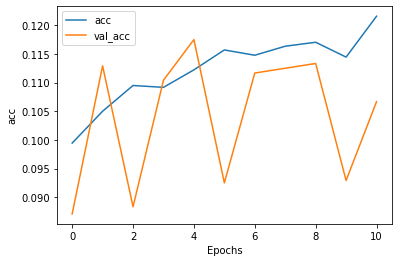

In [158]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()
plot_graphs(history3, 'acc')

# Model 4: Google W2V, Bi LSTM 64, Bi LSTM 32

In [ ]:
# Pre-trained word2vec + https://www.tensorflow.org/tutorials/text/text_classification_rnn
# Still worse than the tf-idf baseline
model4 = Sequential([
    Embedding(len(model_2.wv.vocab) + 1 ,
                    300,
                    input_length  = X.shape[1],
                    weights = [embedding_matrix],
                    trainable=False),
    Bidirectional(LSTM(64,  return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(12)
])

In [ ]:
model4.compile(optimizer=keras.optimizers.Nadam(lr=0.005),
               loss="mse", # Use sparse categorical crossentropy when your classes are mutually exclusive (e.g. when each sample belongs exactly to one class) and categorical crossentropy when one sample can have multiple classes or labels are soft probabilities (like [0.5, 0.3, 0.2]).
               metrics=['acc']
              )
batch = 256
epochs = 100
history4 = model4.fit(X_train, y_train, 
                     batch, 
                     epochs = epochs, 
                     callbacks=callbacks,
                     validation_data = (X_test, y_test)
                    ) #plot_graphs(history3, 'accuracy')

Train on 21600 samples, validate on 2400 samples
Epoch 1/100
21600/21600 [==============================] - 2158s 100ms/sample - loss: 0.0807 - acc: 0.0817 - val_loss: 0.0764 - val_acc: 0.0992
Epoch 2/100
17920/21600 [=======================>......] - ETA: 5:39 - loss: 0.0764 - acc: 0.0831

### N-Shot Learning for Text Classification
https://medium.com/@prabhnoor0212/siamese-network-keras-31a3a8f37d04
(https://github.com/prabhnoor0212/Siamese-Network-Text-Similarity/blob/master/quora_siamese.ipynb )

In [1]:
features

NameError: name 'features' is not defined